#  I  made some modifications for this sample

# Import packages

In [1]:
# Numerical Operations
import math
import numpy as np

# Reading/Writing Data
import pandas as pd
import os
import csv

# For Progress Bar
from tqdm import tqdm

# Pytorch
import torch 
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split

# For Plotting
import matplotlib.pyplot as plt

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(3407)

# Args

In [2]:
class Args:
    def __init__(self) -> None:

        '''***********- model params -*************'''
        self.model_name = "hw1"

        '''***********- data path -*************'''
        self.data_path = '../../../data/hw1/'
        self.train_file='covid.train.csv'
        self.val_file = ''
        self.test_file = 'covid.test.csv'
        self.submit_file = '../../../submit/{}.csv'.format(self.model_name)

        '''***********- model path -*************'''
        self.MODEL_PATH = '../../../ckpts/{}'.format(self.model_name)
        if not os.path.exists(self.MODEL_PATH):
            os.makedirs(self.MODEL_PATH)

        '''***********- cpu or gpu and dara parallel -*************'''
        # self.gpus = [] # cpu
        # self.gpus = [0] # single gpu
        self.gpus = [0] # multi gpu
        self.WORKERS = 5 # num of workers for data loader

        '''***********- Hyper Arguments -*************'''
        self.rand_seed=40
        self.batch_size = 256
        self.lr = 1e-5
        self.epochs = 200
        self.split_ratio = 0.2
        self.momentum = 0.9
        self.patience = 100

# Utils

In [3]:
def train_valid_split(data_set, valid_ratio, seed):
    '''Split provided training data into training set and validation set'''
    valid_set_size = int(valid_ratio * len(data_set)) 
    train_set_size = len(data_set) - valid_set_size
    train_set, valid_set = random_split(data_set, [train_set_size, valid_set_size], generator=torch.Generator().manual_seed(seed))
    return np.array(train_set), np.array(valid_set)

# Dataset

In [4]:
class COVID19Dataset(Dataset):
    '''
    x: Features.
    y: Targets, if none, do prediction.
    '''
    def __init__(self, x, y=None):
        if y is None:
            self.y = y
        else:
            self.y = torch.FloatTensor(y)
        self.x = torch.FloatTensor(x)

    def __getitem__(self, idx):
        if self.y is None:
            return self.x[idx]
        else:
            return self.x[idx], self.y[idx]

    def __len__(self):
        return len(self.x)

# Model

In [5]:
# baseline
class My_Model(nn.Module):
    def __init__(self, input_dim):
        super(My_Model, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 1)
        )
    
    def forward(self, x):
        x = self.net(x)
        x = x.squeeze(1)
        return x

# Feature selection

In [6]:
def select_feat(train_data, valid_data, test_data, select_all=True):
    '''Selects useful features to perform regression'''
    y_train, y_valid = train_data[:,-1], valid_data[:,-1]
    raw_x_train, raw_x_valid, raw_x_test = train_data[:,:-1], valid_data[:,:-1], test_data

    if select_all:
        feat_idx = list(range(raw_x_train.shape[1]))
    else:
        # 计算每个特征与y_train的相关系数
        correlations = np.array([np.corrcoef(raw_x_train[:, i], y_train)[0, 1] for i in range(raw_x_train.shape[1])])
        # 选择相关系数绝对值大于0.1的特征
        feat_idx = np.where(np.abs(correlations) > 0.1)[0]
        
    return raw_x_train[:,feat_idx], raw_x_valid[:,feat_idx], raw_x_test[:,feat_idx], y_train, y_valid

# Trainer

In [7]:
def trainer():
    print("***********- ***********- Init -*************")
    args = Args()

    print("***********- ***********- Read data and processing -*************")
    print("Loading data...")
    train_data = pd.read_csv(args.data_path+args.train_file).values
    test_data = pd.read_csv(args.data_path+args.test_file).values
    train_data, valid_data = train_valid_split(train_data, args.split_ratio, args.rand_seed)
    # Print out the data size.
    print(f"""train_data size: {train_data.shape} 
          valid_data size: {valid_data.shape} 
          test_data size: {test_data.shape}""")

    print("Selecting features...")
    x_train, x_valid, x_test, y_train, y_valid = select_feat(train_data, valid_data, test_data, select_all=False)
    # Print out the number of features.
    print(f'number of features: {x_train.shape[1]}')

    train_dataset, val_dataset, test_dataset = COVID19Dataset(x_train, y_train), \
                                                COVID19Dataset(x_valid, y_valid), \
                                                COVID19Dataset(x_test)
    train_dataloader = DataLoader(dataset=train_dataset, batch_size=args.batch_size, shuffle=True, pin_memory=True, num_workers=args.WORKERS)
    val_dataloader = DataLoader(dataset=val_dataset, batch_size=args.batch_size, shuffle=True, pin_memory=True, num_workers=args.WORKERS)

    print("***********- ***********- Loading model -*************")
    if(len(args.gpus) == 0):
        model = My_Model(input_dim=x_train.shape[1])
        print("***********- ***********- Using CPU -*************")
    elif(len(args.gpus) == 1):
        model = My_Model(input_dim=x_train.shape[1]).cuda()
        print("***********- ***********- Using Single GPU -*************")
    else:
        gpus = ','.join(str(i) for i in args.gpus)
        os.environ["CUDA_VISIBLE_DEVICES"] = gpus
        model = My_Model(input_dim=x_train.shape[1]).cuda()
        gpus = [i for i in range(len(args.gpus))]
        model = torch.nn.DataParallel(model, device_ids=gpus)
        print("***********- ***********- Using Multi GPU -*************")
    
    model_best_path=args.MODEL_PATH+'/{}_best_params.pth'.format(args.model_name)
    model_final_path=args.MODEL_PATH+'/{}_final_params.pth'.format(args.model_name)
    
    criterion = torch.nn.MSELoss(reduction='mean')
    optimizer = torch.optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)

    print("***********- ***********- Training begin -*************")
    train_epochs_loss = []
    # train_epochs_mse = []
    valid_epochs_loss = []
    # valid_epochs_mse = []
    val_inf = np.inf
    patience_counter = 0
    for epoch in range(args.epochs):
        model.train()
        train_epoch_loss = []
        # train_epoch_mse = []
        # =========================train=======================
        for idx, (X, y) in enumerate(tqdm(train_dataloader)):
            if (len(args.gpus) > 0):
                X, y = X.cuda(), y.cuda()
            outputs = model(X)
            optimizer.zero_grad()
            loss = criterion(outputs, y)
            # mse = torch.nn.functional.mse_loss(outputs, y)
            loss.backward()
            # torch.nn.utils.clip_grad_norm_(model.parameters(), 2.0) #用来梯度裁剪
            optimizer.step()
            train_epoch_loss.append(loss.item())
            # train_epoch_mse.append(mse.item())
        train_epochs_loss.append(np.average(train_epoch_loss))
        # train_epochs_mse.append(np.average(train_epoch_mse))
        # print("Train epoch = {}, loss = {:.4f}, mse = {:.4f}".format(epoch + 1, np.average(train_epoch_loss), np.average(train_epoch_mse)))
        print("Train epoch = {}, loss = {:.4f}".format(epoch + 1, np.average(train_epoch_loss)))
        # =========================val=========================
        with torch.no_grad():
            model.eval()
            val_epoch_loss = []
            # val_epoch_mse = []
            for idx, (X, y) in enumerate(tqdm(val_dataloader)):
                if (len(args.gpus) > 0):
                    X, y = X.cuda(), y.cuda()
                outputs = model(X)
                loss = criterion(outputs, y)
                # mse = torch.nn.functional.mse_loss(outputs, y)
                val_epoch_loss.append(loss.item())
                # val_epoch_mse.append(mse.item())
            if np.average(val_epoch_loss) < val_inf:
                val_inf = np.average(val_epoch_loss)
                torch.save(model.state_dict(), model_best_path)
                patience_counter = 0
            else:
                patience_counter += 1
            valid_epochs_loss.append(np.average(val_epoch_loss))
            # valid_epochs_mse.append(np.average(val_epoch_mse))
            # print("Valid epoch = {}, loss = {:.4f}, mse = {:.4f}".format(epoch + 1, np.average(val_epoch_loss), np.average(val_epoch_mse)))
            print("Valid epoch = {}, loss = {:.4f}".format(epoch + 1, np.average(val_epoch_loss)))
            if patience_counter >= args.patience:
                break
            
    torch.save(model.state_dict(), model_final_path)
    print("***********- ***********- Training finished -*************")
    return train_epochs_loss, valid_epochs_loss

# Train

In [8]:
train_epochs_loss, valid_epochs_loss = trainer()

***********- ***********- Init -*************
***********- ***********- Read data and processing -*************
Loading data...
train_data size: (2160, 118) 
          valid_data size: (539, 118) 
          test_data size: (1078, 117)
Selecting features...
number of features: 86
***********- ***********- Loading model -*************
***********- ***********- Using Single GPU -*************
***********- ***********- Training begin -*************


100%|██████████| 9/9 [00:16<00:00,  1.86s/it]


Train epoch = 1, loss = 50.0617


100%|██████████| 3/3 [00:00<00:00,  4.89it/s]


Valid epoch = 1, loss = 40.9478


100%|██████████| 9/9 [00:00<00:00, 15.75it/s]


Train epoch = 2, loss = 39.7646


100%|██████████| 3/3 [00:00<00:00,  5.35it/s]


Valid epoch = 2, loss = 36.8549


100%|██████████| 9/9 [00:00<00:00, 13.08it/s]


Train epoch = 3, loss = 34.4686


100%|██████████| 3/3 [00:00<00:00,  4.69it/s]


Valid epoch = 3, loss = 28.4338


100%|██████████| 9/9 [00:00<00:00, 15.19it/s]


Train epoch = 4, loss = 30.4051


100%|██████████| 3/3 [00:00<00:00,  6.26it/s]


Valid epoch = 4, loss = 24.8716


100%|██████████| 9/9 [00:00<00:00, 12.11it/s]


Train epoch = 5, loss = 29.3821


100%|██████████| 3/3 [00:00<00:00,  4.95it/s]


Valid epoch = 5, loss = 23.4037


100%|██████████| 9/9 [00:00<00:00, 15.78it/s]


Train epoch = 6, loss = 24.8360


100%|██████████| 3/3 [00:00<00:00,  5.69it/s]


Valid epoch = 6, loss = 24.8568


100%|██████████| 9/9 [00:00<00:00, 14.97it/s]


Train epoch = 7, loss = 22.4050


100%|██████████| 3/3 [00:00<00:00,  5.33it/s]


Valid epoch = 7, loss = 26.8522


100%|██████████| 9/9 [00:00<00:00, 10.64it/s]


Train epoch = 8, loss = 20.1177


100%|██████████| 3/3 [00:00<00:00,  5.47it/s]


Valid epoch = 8, loss = 14.8235


100%|██████████| 9/9 [00:00<00:00, 12.03it/s]


Train epoch = 9, loss = 16.1718


100%|██████████| 3/3 [00:00<00:00,  5.17it/s]


Valid epoch = 9, loss = 14.7612


100%|██████████| 9/9 [00:00<00:00, 14.71it/s]


Train epoch = 10, loss = 29.3988


100%|██████████| 3/3 [00:00<00:00,  5.58it/s]


Valid epoch = 10, loss = 44.1645


100%|██████████| 9/9 [00:00<00:00, 11.96it/s]


Train epoch = 11, loss = 27.1924


100%|██████████| 3/3 [00:00<00:00,  5.98it/s]


Valid epoch = 11, loss = 30.4170


100%|██████████| 9/9 [00:00<00:00, 13.24it/s]


Train epoch = 12, loss = 21.8202


100%|██████████| 3/3 [00:00<00:00,  5.07it/s]


Valid epoch = 12, loss = 31.2418


100%|██████████| 9/9 [00:00<00:00, 12.84it/s]


Train epoch = 13, loss = 17.2846


100%|██████████| 3/3 [00:00<00:00,  5.23it/s]


Valid epoch = 13, loss = 15.7736


100%|██████████| 9/9 [00:00<00:00, 13.52it/s]


Train epoch = 14, loss = 17.5250


100%|██████████| 3/3 [00:00<00:00,  4.95it/s]


Valid epoch = 14, loss = 33.3281


100%|██████████| 9/9 [00:00<00:00, 14.12it/s]


Train epoch = 15, loss = 17.1045


100%|██████████| 3/3 [00:00<00:00,  5.08it/s]


Valid epoch = 15, loss = 13.0632


100%|██████████| 9/9 [00:00<00:00, 16.53it/s]


Train epoch = 16, loss = 10.8542


100%|██████████| 3/3 [00:00<00:00,  6.15it/s]


Valid epoch = 16, loss = 10.7907


100%|██████████| 9/9 [00:00<00:00, 16.74it/s]


Train epoch = 17, loss = 8.8030


100%|██████████| 3/3 [00:00<00:00,  6.08it/s]


Valid epoch = 17, loss = 10.6561


100%|██████████| 9/9 [00:00<00:00, 16.00it/s]


Train epoch = 18, loss = 16.7369


100%|██████████| 3/3 [00:00<00:00,  4.71it/s]


Valid epoch = 18, loss = 12.2952


100%|██████████| 9/9 [00:00<00:00, 13.52it/s]


Train epoch = 19, loss = 17.3934


100%|██████████| 3/3 [00:00<00:00,  5.04it/s]


Valid epoch = 19, loss = 17.0596


100%|██████████| 9/9 [00:00<00:00, 17.17it/s]


Train epoch = 20, loss = 16.3504


100%|██████████| 3/3 [00:00<00:00,  6.05it/s]


Valid epoch = 20, loss = 17.9398


100%|██████████| 9/9 [00:00<00:00, 12.12it/s]


Train epoch = 21, loss = 21.2287


100%|██████████| 3/3 [00:00<00:00,  5.19it/s]


Valid epoch = 21, loss = 18.3486


100%|██████████| 9/9 [00:00<00:00, 16.98it/s]


Train epoch = 22, loss = 15.4167


100%|██████████| 3/3 [00:00<00:00,  5.48it/s]


Valid epoch = 22, loss = 10.0488


100%|██████████| 9/9 [00:00<00:00, 11.97it/s]


Train epoch = 23, loss = 9.5467


100%|██████████| 3/3 [00:00<00:00,  5.60it/s]


Valid epoch = 23, loss = 11.5308


100%|██████████| 9/9 [00:00<00:00, 17.67it/s]


Train epoch = 24, loss = 15.1202


100%|██████████| 3/3 [00:00<00:00,  6.06it/s]


Valid epoch = 24, loss = 7.6976


100%|██████████| 9/9 [00:00<00:00, 12.31it/s]


Train epoch = 25, loss = 19.9248


100%|██████████| 3/3 [00:00<00:00,  5.07it/s]


Valid epoch = 25, loss = 10.9959


100%|██████████| 9/9 [00:00<00:00, 16.49it/s]


Train epoch = 26, loss = 13.7035


100%|██████████| 3/3 [00:00<00:00,  5.72it/s]


Valid epoch = 26, loss = 11.0905


100%|██████████| 9/9 [00:00<00:00, 17.57it/s]


Train epoch = 27, loss = 9.8520


100%|██████████| 3/3 [00:00<00:00,  5.05it/s]


Valid epoch = 27, loss = 9.7348


100%|██████████| 9/9 [00:00<00:00, 16.62it/s]


Train epoch = 28, loss = 8.7083


100%|██████████| 3/3 [00:00<00:00,  5.23it/s]


Valid epoch = 28, loss = 14.8882


100%|██████████| 9/9 [00:00<00:00, 15.73it/s]


Train epoch = 29, loss = 8.7346


100%|██████████| 3/3 [00:00<00:00,  5.41it/s]


Valid epoch = 29, loss = 7.4817


100%|██████████| 9/9 [00:00<00:00, 17.23it/s]


Train epoch = 30, loss = 7.4933


100%|██████████| 3/3 [00:00<00:00,  5.00it/s]


Valid epoch = 30, loss = 5.7686


100%|██████████| 9/9 [00:00<00:00, 15.36it/s]


Train epoch = 31, loss = 8.2334


100%|██████████| 3/3 [00:00<00:00,  5.83it/s]


Valid epoch = 31, loss = 8.3970


100%|██████████| 9/9 [00:00<00:00, 16.74it/s]


Train epoch = 32, loss = 10.1879


100%|██████████| 3/3 [00:00<00:00,  6.05it/s]


Valid epoch = 32, loss = 15.1086


100%|██████████| 9/9 [00:00<00:00, 16.19it/s]


Train epoch = 33, loss = 11.3695


100%|██████████| 3/3 [00:00<00:00,  6.07it/s]


Valid epoch = 33, loss = 13.5206


100%|██████████| 9/9 [00:00<00:00, 17.51it/s]


Train epoch = 34, loss = 7.4821


100%|██████████| 3/3 [00:00<00:00,  5.60it/s]


Valid epoch = 34, loss = 5.9826


100%|██████████| 9/9 [00:00<00:00, 14.55it/s]


Train epoch = 35, loss = 6.3616


100%|██████████| 3/3 [00:00<00:00,  6.04it/s]


Valid epoch = 35, loss = 9.4775


100%|██████████| 9/9 [00:00<00:00, 15.15it/s]


Train epoch = 36, loss = 9.2825


100%|██████████| 3/3 [00:00<00:00,  5.02it/s]


Valid epoch = 36, loss = 5.8399


100%|██████████| 9/9 [00:00<00:00, 16.95it/s]


Train epoch = 37, loss = 6.7985


100%|██████████| 3/3 [00:00<00:00,  5.78it/s]


Valid epoch = 37, loss = 5.4675


100%|██████████| 9/9 [00:00<00:00, 16.99it/s]


Train epoch = 38, loss = 7.0839


100%|██████████| 3/3 [00:00<00:00,  5.17it/s]


Valid epoch = 38, loss = 7.4274


100%|██████████| 9/9 [00:00<00:00, 13.47it/s]


Train epoch = 39, loss = 9.1501


100%|██████████| 3/3 [00:00<00:00,  6.23it/s]


Valid epoch = 39, loss = 7.6436


100%|██████████| 9/9 [00:00<00:00, 17.79it/s]


Train epoch = 40, loss = 7.7696


100%|██████████| 3/3 [00:00<00:00,  6.13it/s]


Valid epoch = 40, loss = 5.6422


100%|██████████| 9/9 [00:00<00:00, 14.89it/s]


Train epoch = 41, loss = 7.3921


100%|██████████| 3/3 [00:00<00:00,  6.33it/s]


Valid epoch = 41, loss = 6.8490


100%|██████████| 9/9 [00:00<00:00, 14.84it/s]


Train epoch = 42, loss = 8.6604


100%|██████████| 3/3 [00:00<00:00,  6.35it/s]


Valid epoch = 42, loss = 5.6874


100%|██████████| 9/9 [00:00<00:00, 17.53it/s]


Train epoch = 43, loss = 6.8110


100%|██████████| 3/3 [00:00<00:00,  6.12it/s]


Valid epoch = 43, loss = 6.1520


100%|██████████| 9/9 [00:00<00:00, 17.31it/s]


Train epoch = 44, loss = 6.6963


100%|██████████| 3/3 [00:00<00:00,  6.21it/s]


Valid epoch = 44, loss = 11.2987


100%|██████████| 9/9 [00:00<00:00, 14.63it/s]


Train epoch = 45, loss = 7.3256


100%|██████████| 3/3 [00:00<00:00,  5.77it/s]


Valid epoch = 45, loss = 5.3511


100%|██████████| 9/9 [00:00<00:00, 16.35it/s]


Train epoch = 46, loss = 6.5996


100%|██████████| 3/3 [00:00<00:00,  5.37it/s]


Valid epoch = 46, loss = 6.7076


100%|██████████| 9/9 [00:00<00:00, 15.41it/s]


Train epoch = 47, loss = 5.7009


100%|██████████| 3/3 [00:00<00:00,  5.91it/s]


Valid epoch = 47, loss = 6.5813


100%|██████████| 9/9 [00:00<00:00, 16.00it/s]


Train epoch = 48, loss = 5.8517


100%|██████████| 3/3 [00:00<00:00,  5.26it/s]


Valid epoch = 48, loss = 6.0177


100%|██████████| 9/9 [00:00<00:00, 15.32it/s]


Train epoch = 49, loss = 6.0494


100%|██████████| 3/3 [00:00<00:00,  5.89it/s]


Valid epoch = 49, loss = 5.2399


100%|██████████| 9/9 [00:00<00:00, 17.70it/s]


Train epoch = 50, loss = 7.1193


100%|██████████| 3/3 [00:00<00:00,  5.69it/s]


Valid epoch = 50, loss = 6.8422


100%|██████████| 9/9 [00:00<00:00, 16.15it/s]


Train epoch = 51, loss = 9.0393


100%|██████████| 3/3 [00:00<00:00,  4.52it/s]


Valid epoch = 51, loss = 14.5467


100%|██████████| 9/9 [00:00<00:00, 14.10it/s]


Train epoch = 52, loss = 8.8347


100%|██████████| 3/3 [00:00<00:00,  4.70it/s]


Valid epoch = 52, loss = 7.8760


100%|██████████| 9/9 [00:00<00:00, 16.20it/s]


Train epoch = 53, loss = 5.8579


100%|██████████| 3/3 [00:00<00:00,  6.01it/s]


Valid epoch = 53, loss = 6.1505


100%|██████████| 9/9 [00:00<00:00, 16.69it/s]


Train epoch = 54, loss = 5.5193


100%|██████████| 3/3 [00:00<00:00,  5.54it/s]


Valid epoch = 54, loss = 4.9509


100%|██████████| 9/9 [00:00<00:00, 14.38it/s]


Train epoch = 55, loss = 5.5155


100%|██████████| 3/3 [00:00<00:00,  5.11it/s]


Valid epoch = 55, loss = 7.4635


100%|██████████| 9/9 [00:00<00:00, 15.18it/s]


Train epoch = 56, loss = 7.3648


100%|██████████| 3/3 [00:00<00:00,  5.26it/s]


Valid epoch = 56, loss = 6.3833


100%|██████████| 9/9 [00:00<00:00, 15.69it/s]


Train epoch = 57, loss = 6.1889


100%|██████████| 3/3 [00:00<00:00,  5.98it/s]


Valid epoch = 57, loss = 7.0699


100%|██████████| 9/9 [00:00<00:00, 14.68it/s]


Train epoch = 58, loss = 5.7318


100%|██████████| 3/3 [00:00<00:00,  4.77it/s]


Valid epoch = 58, loss = 8.8729


100%|██████████| 9/9 [00:00<00:00, 13.87it/s]


Train epoch = 59, loss = 7.6359


100%|██████████| 3/3 [00:00<00:00,  4.87it/s]


Valid epoch = 59, loss = 9.9289


100%|██████████| 9/9 [00:00<00:00, 15.16it/s]


Train epoch = 60, loss = 5.8883


100%|██████████| 3/3 [00:00<00:00,  5.54it/s]


Valid epoch = 60, loss = 5.6816


100%|██████████| 9/9 [00:00<00:00, 15.54it/s]


Train epoch = 61, loss = 6.3448


100%|██████████| 3/3 [00:00<00:00,  5.97it/s]


Valid epoch = 61, loss = 6.1944


100%|██████████| 9/9 [00:00<00:00, 16.09it/s]


Train epoch = 62, loss = 5.9027


100%|██████████| 3/3 [00:00<00:00,  4.89it/s]


Valid epoch = 62, loss = 4.6235


100%|██████████| 9/9 [00:00<00:00, 14.70it/s]


Train epoch = 63, loss = 5.7152


100%|██████████| 3/3 [00:00<00:00,  5.00it/s]


Valid epoch = 63, loss = 5.4622


100%|██████████| 9/9 [00:00<00:00, 15.31it/s]


Train epoch = 64, loss = 5.9349


100%|██████████| 3/3 [00:00<00:00,  5.24it/s]


Valid epoch = 64, loss = 5.6818


100%|██████████| 9/9 [00:00<00:00, 15.27it/s]


Train epoch = 65, loss = 5.0384


100%|██████████| 3/3 [00:00<00:00,  5.79it/s]


Valid epoch = 65, loss = 5.4597


100%|██████████| 9/9 [00:00<00:00, 15.32it/s]


Train epoch = 66, loss = 5.9143


100%|██████████| 3/3 [00:00<00:00,  5.91it/s]


Valid epoch = 66, loss = 8.5325


100%|██████████| 9/9 [00:00<00:00, 17.31it/s]


Train epoch = 67, loss = 6.5025


100%|██████████| 3/3 [00:00<00:00,  6.05it/s]


Valid epoch = 67, loss = 4.9956


100%|██████████| 9/9 [00:00<00:00, 16.96it/s]


Train epoch = 68, loss = 6.1735


100%|██████████| 3/3 [00:00<00:00,  6.18it/s]


Valid epoch = 68, loss = 5.6649


100%|██████████| 9/9 [00:00<00:00, 17.21it/s]


Train epoch = 69, loss = 5.5109


100%|██████████| 3/3 [00:00<00:00,  6.22it/s]


Valid epoch = 69, loss = 4.4603


100%|██████████| 9/9 [00:00<00:00, 16.31it/s]


Train epoch = 70, loss = 6.3158


100%|██████████| 3/3 [00:00<00:00,  5.27it/s]


Valid epoch = 70, loss = 9.6403


100%|██████████| 9/9 [00:00<00:00, 14.44it/s]


Train epoch = 71, loss = 7.7414


100%|██████████| 3/3 [00:00<00:00,  5.33it/s]


Valid epoch = 71, loss = 7.9823


100%|██████████| 9/9 [00:00<00:00, 14.30it/s]


Train epoch = 72, loss = 7.3673


100%|██████████| 3/3 [00:00<00:00,  4.67it/s]


Valid epoch = 72, loss = 5.4496


100%|██████████| 9/9 [00:00<00:00, 13.46it/s]


Train epoch = 73, loss = 6.7406


100%|██████████| 3/3 [00:00<00:00,  5.48it/s]


Valid epoch = 73, loss = 5.3723


100%|██████████| 9/9 [00:00<00:00, 17.78it/s]


Train epoch = 74, loss = 6.4890


100%|██████████| 3/3 [00:00<00:00,  6.23it/s]


Valid epoch = 74, loss = 4.4945


100%|██████████| 9/9 [00:00<00:00, 15.40it/s]


Train epoch = 75, loss = 5.7976


100%|██████████| 3/3 [00:00<00:00,  6.34it/s]


Valid epoch = 75, loss = 6.3630


100%|██████████| 9/9 [00:00<00:00, 17.49it/s]


Train epoch = 76, loss = 5.2605


100%|██████████| 3/3 [00:00<00:00,  5.10it/s]


Valid epoch = 76, loss = 5.5051


100%|██████████| 9/9 [00:00<00:00, 16.89it/s]


Train epoch = 77, loss = 4.9914


100%|██████████| 3/3 [00:00<00:00,  6.27it/s]


Valid epoch = 77, loss = 8.8130


100%|██████████| 9/9 [00:00<00:00, 17.87it/s]


Train epoch = 78, loss = 7.3561


100%|██████████| 3/3 [00:00<00:00,  6.28it/s]


Valid epoch = 78, loss = 14.6392


100%|██████████| 9/9 [00:00<00:00, 17.31it/s]


Train epoch = 79, loss = 8.9944


100%|██████████| 3/3 [00:00<00:00,  6.35it/s]


Valid epoch = 79, loss = 5.0491


100%|██████████| 9/9 [00:00<00:00, 18.25it/s]


Train epoch = 80, loss = 8.3751


100%|██████████| 3/3 [00:00<00:00,  6.27it/s]


Valid epoch = 80, loss = 11.4432


100%|██████████| 9/9 [00:00<00:00, 15.60it/s]


Train epoch = 81, loss = 6.8253


100%|██████████| 3/3 [00:00<00:00,  4.46it/s]


Valid epoch = 81, loss = 6.6970


100%|██████████| 9/9 [00:00<00:00, 12.84it/s]


Train epoch = 82, loss = 5.5878


100%|██████████| 3/3 [00:00<00:00,  6.11it/s]


Valid epoch = 82, loss = 5.8894


100%|██████████| 9/9 [00:00<00:00, 11.61it/s]


Train epoch = 83, loss = 5.6324


100%|██████████| 3/3 [00:00<00:00,  6.09it/s]


Valid epoch = 83, loss = 4.7803


100%|██████████| 9/9 [00:00<00:00, 17.01it/s]


Train epoch = 84, loss = 5.4170


100%|██████████| 3/3 [00:00<00:00,  5.17it/s]


Valid epoch = 84, loss = 9.3458


100%|██████████| 9/9 [00:00<00:00, 14.77it/s]


Train epoch = 85, loss = 6.9252


100%|██████████| 3/3 [00:00<00:00,  5.89it/s]


Valid epoch = 85, loss = 4.6680


100%|██████████| 9/9 [00:00<00:00, 17.04it/s]


Train epoch = 86, loss = 5.6594


100%|██████████| 3/3 [00:00<00:00,  6.30it/s]


Valid epoch = 86, loss = 5.6341


100%|██████████| 9/9 [00:00<00:00, 16.67it/s]


Train epoch = 87, loss = 5.9007


100%|██████████| 3/3 [00:00<00:00,  5.86it/s]


Valid epoch = 87, loss = 4.5904


100%|██████████| 9/9 [00:00<00:00, 16.74it/s]


Train epoch = 88, loss = 6.4238


100%|██████████| 3/3 [00:00<00:00,  5.82it/s]


Valid epoch = 88, loss = 5.1935


100%|██████████| 9/9 [00:00<00:00, 17.43it/s]


Train epoch = 89, loss = 5.6822


100%|██████████| 3/3 [00:00<00:00,  5.07it/s]


Valid epoch = 89, loss = 4.8032


100%|██████████| 9/9 [00:00<00:00, 15.58it/s]


Train epoch = 90, loss = 5.4219


100%|██████████| 3/3 [00:00<00:00,  5.90it/s]


Valid epoch = 90, loss = 5.2545


100%|██████████| 9/9 [00:00<00:00, 17.71it/s]


Train epoch = 91, loss = 4.8903


100%|██████████| 3/3 [00:00<00:00,  5.82it/s]


Valid epoch = 91, loss = 6.1671


100%|██████████| 9/9 [00:00<00:00, 14.33it/s]


Train epoch = 92, loss = 6.1397


100%|██████████| 3/3 [00:00<00:00,  5.92it/s]


Valid epoch = 92, loss = 12.0052


100%|██████████| 9/9 [00:00<00:00, 14.45it/s]


Train epoch = 93, loss = 7.7104


100%|██████████| 3/3 [00:00<00:00,  6.27it/s]


Valid epoch = 93, loss = 15.0306


100%|██████████| 9/9 [00:00<00:00, 16.62it/s]


Train epoch = 94, loss = 7.7434


100%|██████████| 3/3 [00:00<00:00,  5.35it/s]


Valid epoch = 94, loss = 7.0485


100%|██████████| 9/9 [00:00<00:00, 13.57it/s]


Train epoch = 95, loss = 5.5319


100%|██████████| 3/3 [00:00<00:00,  5.17it/s]


Valid epoch = 95, loss = 4.8874


100%|██████████| 9/9 [00:00<00:00, 16.33it/s]


Train epoch = 96, loss = 5.6478


100%|██████████| 3/3 [00:00<00:00,  6.22it/s]


Valid epoch = 96, loss = 9.9589


100%|██████████| 9/9 [00:00<00:00, 14.85it/s]


Train epoch = 97, loss = 6.7825


100%|██████████| 3/3 [00:00<00:00,  5.96it/s]


Valid epoch = 97, loss = 6.1808


100%|██████████| 9/9 [00:00<00:00, 17.02it/s]


Train epoch = 98, loss = 6.2926


100%|██████████| 3/3 [00:00<00:00,  6.21it/s]


Valid epoch = 98, loss = 4.3202


100%|██████████| 9/9 [00:00<00:00, 12.64it/s]


Train epoch = 99, loss = 6.3270


100%|██████████| 3/3 [00:00<00:00,  6.04it/s]


Valid epoch = 99, loss = 7.7028


100%|██████████| 9/9 [00:00<00:00, 15.61it/s]


Train epoch = 100, loss = 5.8281


100%|██████████| 3/3 [00:00<00:00,  5.12it/s]


Valid epoch = 100, loss = 10.0752


100%|██████████| 9/9 [00:00<00:00, 16.67it/s]


Train epoch = 101, loss = 6.0460


100%|██████████| 3/3 [00:00<00:00,  5.97it/s]


Valid epoch = 101, loss = 6.6485


100%|██████████| 9/9 [00:00<00:00, 17.19it/s]


Train epoch = 102, loss = 5.0286


100%|██████████| 3/3 [00:00<00:00,  5.35it/s]


Valid epoch = 102, loss = 7.8447


100%|██████████| 9/9 [00:00<00:00, 16.22it/s]


Train epoch = 103, loss = 7.0874


100%|██████████| 3/3 [00:00<00:00,  5.59it/s]


Valid epoch = 103, loss = 5.1423


100%|██████████| 9/9 [00:00<00:00, 17.48it/s]


Train epoch = 104, loss = 5.6020


100%|██████████| 3/3 [00:00<00:00,  6.23it/s]


Valid epoch = 104, loss = 8.3609


100%|██████████| 9/9 [00:00<00:00, 16.93it/s]


Train epoch = 105, loss = 7.7460


100%|██████████| 3/3 [00:00<00:00,  6.02it/s]


Valid epoch = 105, loss = 5.7755


100%|██████████| 9/9 [00:00<00:00, 16.19it/s]


Train epoch = 106, loss = 5.6089


100%|██████████| 3/3 [00:00<00:00,  5.71it/s]


Valid epoch = 106, loss = 4.3575


100%|██████████| 9/9 [00:00<00:00, 15.68it/s]


Train epoch = 107, loss = 5.2512


100%|██████████| 3/3 [00:00<00:00,  5.93it/s]


Valid epoch = 107, loss = 4.7732


100%|██████████| 9/9 [00:00<00:00, 12.84it/s]


Train epoch = 108, loss = 4.8176


100%|██████████| 3/3 [00:00<00:00,  6.03it/s]


Valid epoch = 108, loss = 4.6795


100%|██████████| 9/9 [00:00<00:00, 13.53it/s]


Train epoch = 109, loss = 5.6130


100%|██████████| 3/3 [00:00<00:00,  6.13it/s]


Valid epoch = 109, loss = 8.7843


100%|██████████| 9/9 [00:00<00:00, 13.88it/s]


Train epoch = 110, loss = 5.7859


100%|██████████| 3/3 [00:00<00:00,  6.13it/s]


Valid epoch = 110, loss = 7.0687


100%|██████████| 9/9 [00:00<00:00, 13.28it/s]


Train epoch = 111, loss = 5.3932


100%|██████████| 3/3 [00:00<00:00,  5.10it/s]


Valid epoch = 111, loss = 5.6365


100%|██████████| 9/9 [00:01<00:00,  8.57it/s]


Train epoch = 112, loss = 5.8376


100%|██████████| 3/3 [00:00<00:00,  6.16it/s]


Valid epoch = 112, loss = 6.1645


100%|██████████| 9/9 [00:00<00:00, 13.00it/s]


Train epoch = 113, loss = 4.7877


100%|██████████| 3/3 [00:00<00:00,  6.25it/s]


Valid epoch = 113, loss = 4.6355


100%|██████████| 9/9 [00:00<00:00, 12.84it/s]


Train epoch = 114, loss = 4.4898


100%|██████████| 3/3 [00:00<00:00,  5.95it/s]


Valid epoch = 114, loss = 4.4497


100%|██████████| 9/9 [00:00<00:00, 13.67it/s]


Train epoch = 115, loss = 5.3245


100%|██████████| 3/3 [00:00<00:00,  6.04it/s]


Valid epoch = 115, loss = 5.5326


100%|██████████| 9/9 [00:00<00:00, 13.53it/s]


Train epoch = 116, loss = 4.4157


100%|██████████| 3/3 [00:00<00:00,  6.23it/s]


Valid epoch = 116, loss = 4.8048


100%|██████████| 9/9 [00:00<00:00, 11.95it/s]


Train epoch = 117, loss = 4.2805


100%|██████████| 3/3 [00:00<00:00,  5.90it/s]


Valid epoch = 117, loss = 4.1019


100%|██████████| 9/9 [00:00<00:00, 11.65it/s]


Train epoch = 118, loss = 4.2962


100%|██████████| 3/3 [00:00<00:00,  4.94it/s]


Valid epoch = 118, loss = 6.1503


100%|██████████| 9/9 [00:00<00:00, 13.50it/s]


Train epoch = 119, loss = 4.6334


100%|██████████| 3/3 [00:00<00:00,  6.08it/s]


Valid epoch = 119, loss = 3.7136


100%|██████████| 9/9 [00:00<00:00, 11.89it/s]


Train epoch = 120, loss = 4.3108


100%|██████████| 3/3 [00:00<00:00,  5.96it/s]


Valid epoch = 120, loss = 4.5271


100%|██████████| 9/9 [00:00<00:00, 12.86it/s]


Train epoch = 121, loss = 4.4482


100%|██████████| 3/3 [00:00<00:00,  5.93it/s]


Valid epoch = 121, loss = 7.4024


100%|██████████| 9/9 [00:00<00:00, 13.24it/s]


Train epoch = 122, loss = 4.5201


100%|██████████| 3/3 [00:00<00:00,  6.20it/s]


Valid epoch = 122, loss = 4.8203


100%|██████████| 9/9 [00:00<00:00, 12.47it/s]


Train epoch = 123, loss = 4.3998


100%|██████████| 3/3 [00:00<00:00,  5.78it/s]


Valid epoch = 123, loss = 4.3040


100%|██████████| 9/9 [00:00<00:00, 12.91it/s]


Train epoch = 124, loss = 4.2154


100%|██████████| 3/3 [00:00<00:00,  6.19it/s]


Valid epoch = 124, loss = 7.3103


100%|██████████| 9/9 [00:00<00:00, 11.09it/s]


Train epoch = 125, loss = 5.8578


100%|██████████| 3/3 [00:00<00:00,  5.94it/s]


Valid epoch = 125, loss = 9.2229


100%|██████████| 9/9 [00:00<00:00, 11.96it/s]


Train epoch = 126, loss = 5.8835


100%|██████████| 3/3 [00:00<00:00,  5.50it/s]


Valid epoch = 126, loss = 4.0929


100%|██████████| 9/9 [00:00<00:00, 13.89it/s]


Train epoch = 127, loss = 4.6828


100%|██████████| 3/3 [00:00<00:00,  5.65it/s]


Valid epoch = 127, loss = 3.8336


100%|██████████| 9/9 [00:00<00:00, 11.68it/s]


Train epoch = 128, loss = 5.0027


100%|██████████| 3/3 [00:00<00:00,  5.96it/s]


Valid epoch = 128, loss = 5.1120


100%|██████████| 9/9 [00:00<00:00, 11.62it/s]


Train epoch = 129, loss = 4.7031


100%|██████████| 3/3 [00:00<00:00,  5.61it/s]


Valid epoch = 129, loss = 3.8204


100%|██████████| 9/9 [00:00<00:00, 12.02it/s]


Train epoch = 130, loss = 4.5924


100%|██████████| 3/3 [00:00<00:00,  5.05it/s]


Valid epoch = 130, loss = 5.1536


100%|██████████| 9/9 [00:00<00:00, 13.11it/s]


Train epoch = 131, loss = 4.9534


100%|██████████| 3/3 [00:00<00:00,  6.06it/s]


Valid epoch = 131, loss = 4.2145


100%|██████████| 9/9 [00:00<00:00, 11.19it/s]


Train epoch = 132, loss = 4.4618


100%|██████████| 3/3 [00:00<00:00,  5.89it/s]


Valid epoch = 132, loss = 4.4141


100%|██████████| 9/9 [00:00<00:00, 13.18it/s]


Train epoch = 133, loss = 4.1324


100%|██████████| 3/3 [00:00<00:00,  5.67it/s]


Valid epoch = 133, loss = 4.8369


100%|██████████| 9/9 [00:00<00:00, 13.45it/s]


Train epoch = 134, loss = 4.9957


100%|██████████| 3/3 [00:00<00:00,  6.10it/s]


Valid epoch = 134, loss = 5.5698


100%|██████████| 9/9 [00:00<00:00, 12.99it/s]


Train epoch = 135, loss = 4.8464


100%|██████████| 3/3 [00:00<00:00,  5.00it/s]


Valid epoch = 135, loss = 4.4723


100%|██████████| 9/9 [00:00<00:00, 12.71it/s]


Train epoch = 136, loss = 4.1557


100%|██████████| 3/3 [00:00<00:00,  5.16it/s]


Valid epoch = 136, loss = 5.2765


100%|██████████| 9/9 [00:00<00:00, 13.61it/s]


Train epoch = 137, loss = 4.8143


100%|██████████| 3/3 [00:00<00:00,  6.01it/s]


Valid epoch = 137, loss = 4.3777


100%|██████████| 9/9 [00:00<00:00, 11.70it/s]


Train epoch = 138, loss = 5.8759


100%|██████████| 3/3 [00:00<00:00,  5.68it/s]


Valid epoch = 138, loss = 11.4168


100%|██████████| 9/9 [00:00<00:00, 12.92it/s]


Train epoch = 139, loss = 6.5030


100%|██████████| 3/3 [00:00<00:00,  5.73it/s]


Valid epoch = 139, loss = 7.3583


100%|██████████| 9/9 [00:00<00:00, 12.12it/s]


Train epoch = 140, loss = 5.0010


100%|██████████| 3/3 [00:00<00:00,  5.87it/s]


Valid epoch = 140, loss = 3.4580


100%|██████████| 9/9 [00:00<00:00, 11.27it/s]


Train epoch = 141, loss = 4.5152


100%|██████████| 3/3 [00:00<00:00,  5.41it/s]


Valid epoch = 141, loss = 5.2371


100%|██████████| 9/9 [00:00<00:00, 13.18it/s]


Train epoch = 142, loss = 4.2084


100%|██████████| 3/3 [00:00<00:00,  6.10it/s]


Valid epoch = 142, loss = 7.0257


100%|██████████| 9/9 [00:00<00:00, 13.00it/s]


Train epoch = 143, loss = 4.8009


100%|██████████| 3/3 [00:00<00:00,  5.13it/s]


Valid epoch = 143, loss = 5.1847


100%|██████████| 9/9 [00:00<00:00, 11.31it/s]


Train epoch = 144, loss = 4.6941


100%|██████████| 3/3 [00:00<00:00,  5.87it/s]


Valid epoch = 144, loss = 3.8353


100%|██████████| 9/9 [00:00<00:00, 12.42it/s]


Train epoch = 145, loss = 4.5203


100%|██████████| 3/3 [00:00<00:00,  5.39it/s]


Valid epoch = 145, loss = 3.9579


100%|██████████| 9/9 [00:00<00:00, 11.53it/s]


Train epoch = 146, loss = 4.2987


100%|██████████| 3/3 [00:00<00:00,  5.28it/s]


Valid epoch = 146, loss = 6.5777


100%|██████████| 9/9 [00:00<00:00, 12.28it/s]


Train epoch = 147, loss = 6.2596


100%|██████████| 3/3 [00:00<00:00,  5.24it/s]


Valid epoch = 147, loss = 5.1819


100%|██████████| 9/9 [00:00<00:00, 11.52it/s]


Train epoch = 148, loss = 4.6460


100%|██████████| 3/3 [00:00<00:00,  5.91it/s]


Valid epoch = 148, loss = 5.2065


100%|██████████| 9/9 [00:00<00:00, 12.50it/s]


Train epoch = 149, loss = 5.2549


100%|██████████| 3/3 [00:00<00:00,  5.55it/s]


Valid epoch = 149, loss = 4.8860


100%|██████████| 9/9 [00:00<00:00, 11.83it/s]


Train epoch = 150, loss = 5.2963


100%|██████████| 3/3 [00:00<00:00,  5.79it/s]


Valid epoch = 150, loss = 3.4169


100%|██████████| 9/9 [00:00<00:00, 12.59it/s]


Train epoch = 151, loss = 4.8491


100%|██████████| 3/3 [00:00<00:00,  5.28it/s]


Valid epoch = 151, loss = 4.2755


100%|██████████| 9/9 [00:00<00:00, 12.02it/s]


Train epoch = 152, loss = 4.4719


100%|██████████| 3/3 [00:00<00:00,  5.43it/s]


Valid epoch = 152, loss = 3.4646


100%|██████████| 9/9 [00:00<00:00,  9.97it/s]


Train epoch = 153, loss = 4.0944


100%|██████████| 3/3 [00:00<00:00,  5.00it/s]


Valid epoch = 153, loss = 5.7158


100%|██████████| 9/9 [00:00<00:00, 12.07it/s]


Train epoch = 154, loss = 4.5879


100%|██████████| 3/3 [00:00<00:00,  4.87it/s]


Valid epoch = 154, loss = 5.0600


100%|██████████| 9/9 [00:00<00:00, 10.67it/s]


Train epoch = 155, loss = 4.3146


100%|██████████| 3/3 [00:00<00:00,  3.89it/s]


Valid epoch = 155, loss = 4.2773


100%|██████████| 9/9 [00:00<00:00, 11.52it/s]


Train epoch = 156, loss = 4.0638


100%|██████████| 3/3 [00:00<00:00,  3.99it/s]


Valid epoch = 156, loss = 4.7403


100%|██████████| 9/9 [00:00<00:00, 12.56it/s]


Train epoch = 157, loss = 4.1560


100%|██████████| 3/3 [00:00<00:00,  4.21it/s]


Valid epoch = 157, loss = 4.4471


100%|██████████| 9/9 [00:00<00:00, 12.71it/s]


Train epoch = 158, loss = 3.9303


100%|██████████| 3/3 [00:00<00:00,  4.23it/s]


Valid epoch = 158, loss = 3.9761


100%|██████████| 9/9 [00:00<00:00, 12.56it/s]


Train epoch = 159, loss = 4.1344


100%|██████████| 3/3 [00:00<00:00,  3.71it/s]


Valid epoch = 159, loss = 5.5486


100%|██████████| 9/9 [00:00<00:00, 10.85it/s]


Train epoch = 160, loss = 6.3161


100%|██████████| 3/3 [00:00<00:00,  4.13it/s]


Valid epoch = 160, loss = 5.7158


100%|██████████| 9/9 [00:00<00:00, 12.01it/s]


Train epoch = 161, loss = 4.7148


100%|██████████| 3/3 [00:00<00:00,  4.46it/s]


Valid epoch = 161, loss = 3.8321


100%|██████████| 9/9 [00:00<00:00, 12.50it/s]


Train epoch = 162, loss = 4.2566


100%|██████████| 3/3 [00:00<00:00,  3.84it/s]


Valid epoch = 162, loss = 4.2618


100%|██████████| 9/9 [00:00<00:00, 12.06it/s]


Train epoch = 163, loss = 4.2154


100%|██████████| 3/3 [00:00<00:00,  4.46it/s]


Valid epoch = 163, loss = 4.0957


100%|██████████| 9/9 [00:00<00:00, 12.15it/s]


Train epoch = 164, loss = 5.6854


100%|██████████| 3/3 [00:00<00:00,  4.23it/s]


Valid epoch = 164, loss = 3.6963


100%|██████████| 9/9 [00:00<00:00, 11.83it/s]


Train epoch = 165, loss = 4.4244


100%|██████████| 3/3 [00:00<00:00,  4.55it/s]


Valid epoch = 165, loss = 4.1320


100%|██████████| 9/9 [00:00<00:00, 12.07it/s]


Train epoch = 166, loss = 4.1294


100%|██████████| 3/3 [00:00<00:00,  4.22it/s]


Valid epoch = 166, loss = 3.7415


100%|██████████| 9/9 [00:00<00:00, 12.82it/s]


Train epoch = 167, loss = 3.9640


100%|██████████| 3/3 [00:00<00:00,  4.36it/s]


Valid epoch = 167, loss = 3.9765


100%|██████████| 9/9 [00:00<00:00, 11.82it/s]


Train epoch = 168, loss = 5.1609


100%|██████████| 3/3 [00:00<00:00,  4.52it/s]


Valid epoch = 168, loss = 6.4788


100%|██████████| 9/9 [00:00<00:00, 12.30it/s]


Train epoch = 169, loss = 5.6923


100%|██████████| 3/3 [00:00<00:00,  4.43it/s]


Valid epoch = 169, loss = 4.9571


100%|██████████| 9/9 [00:00<00:00, 11.99it/s]


Train epoch = 170, loss = 5.1473


100%|██████████| 3/3 [00:00<00:00,  4.42it/s]


Valid epoch = 170, loss = 3.9705


100%|██████████| 9/9 [00:00<00:00, 12.88it/s]


Train epoch = 171, loss = 4.2249


100%|██████████| 3/3 [00:00<00:00,  4.33it/s]


Valid epoch = 171, loss = 3.6395


100%|██████████| 9/9 [00:00<00:00, 12.04it/s]


Train epoch = 172, loss = 4.3595


100%|██████████| 3/3 [00:00<00:00,  4.26it/s]


Valid epoch = 172, loss = 4.4840


100%|██████████| 9/9 [00:00<00:00, 12.79it/s]


Train epoch = 173, loss = 4.3739


100%|██████████| 3/3 [00:00<00:00,  4.59it/s]


Valid epoch = 173, loss = 4.2902


100%|██████████| 9/9 [00:00<00:00, 12.72it/s]


Train epoch = 174, loss = 7.7989


100%|██████████| 3/3 [00:00<00:00,  4.04it/s]


Valid epoch = 174, loss = 10.5979


100%|██████████| 9/9 [00:00<00:00, 12.26it/s]


Train epoch = 175, loss = 8.8052


100%|██████████| 3/3 [00:00<00:00,  4.27it/s]


Valid epoch = 175, loss = 5.7206


100%|██████████| 9/9 [00:00<00:00, 12.68it/s]


Train epoch = 176, loss = 5.4793


100%|██████████| 3/3 [00:00<00:00,  4.38it/s]


Valid epoch = 176, loss = 3.9774


100%|██████████| 9/9 [00:00<00:00, 11.98it/s]


Train epoch = 177, loss = 5.4771


100%|██████████| 3/3 [00:00<00:00,  4.54it/s]


Valid epoch = 177, loss = 4.9849


100%|██████████| 9/9 [00:00<00:00, 12.18it/s]


Train epoch = 178, loss = 4.8117


100%|██████████| 3/3 [00:00<00:00,  4.59it/s]


Valid epoch = 178, loss = 5.8952


100%|██████████| 9/9 [00:00<00:00, 12.25it/s]


Train epoch = 179, loss = 4.1147


100%|██████████| 3/3 [00:00<00:00,  4.06it/s]


Valid epoch = 179, loss = 3.4610


100%|██████████| 9/9 [00:00<00:00, 12.45it/s]


Train epoch = 180, loss = 4.5925


100%|██████████| 3/3 [00:00<00:00,  4.63it/s]


Valid epoch = 180, loss = 6.3296


100%|██████████| 9/9 [00:00<00:00, 12.56it/s]


Train epoch = 181, loss = 6.9055


100%|██████████| 3/3 [00:00<00:00,  4.32it/s]


Valid epoch = 181, loss = 3.5411


100%|██████████| 9/9 [00:00<00:00, 12.39it/s]


Train epoch = 182, loss = 4.5310


100%|██████████| 3/3 [00:00<00:00,  4.50it/s]


Valid epoch = 182, loss = 3.4291


100%|██████████| 9/9 [00:00<00:00, 11.98it/s]


Train epoch = 183, loss = 4.3195


100%|██████████| 3/3 [00:00<00:00,  4.27it/s]


Valid epoch = 183, loss = 3.6668


100%|██████████| 9/9 [00:00<00:00, 12.49it/s]


Train epoch = 184, loss = 3.9011


100%|██████████| 3/3 [00:00<00:00,  4.53it/s]


Valid epoch = 184, loss = 3.7718


100%|██████████| 9/9 [00:00<00:00, 11.81it/s]


Train epoch = 185, loss = 3.7836


100%|██████████| 3/3 [00:00<00:00,  4.48it/s]


Valid epoch = 185, loss = 4.2000


100%|██████████| 9/9 [00:00<00:00, 11.60it/s]


Train epoch = 186, loss = 3.6966


100%|██████████| 3/3 [00:00<00:00,  3.92it/s]


Valid epoch = 186, loss = 3.5122


100%|██████████| 9/9 [00:00<00:00, 12.00it/s]


Train epoch = 187, loss = 3.6827


100%|██████████| 3/3 [00:00<00:00,  4.46it/s]


Valid epoch = 187, loss = 3.6789


100%|██████████| 9/9 [00:00<00:00, 11.92it/s]


Train epoch = 188, loss = 3.7552


100%|██████████| 3/3 [00:00<00:00,  4.49it/s]


Valid epoch = 188, loss = 4.2128


100%|██████████| 9/9 [00:00<00:00, 12.33it/s]


Train epoch = 189, loss = 3.8645


100%|██████████| 3/3 [00:00<00:00,  4.58it/s]


Valid epoch = 189, loss = 3.6313


100%|██████████| 9/9 [00:00<00:00, 12.58it/s]


Train epoch = 190, loss = 4.4863


100%|██████████| 3/3 [00:00<00:00,  4.54it/s]


Valid epoch = 190, loss = 4.2159


100%|██████████| 9/9 [00:00<00:00, 12.87it/s]


Train epoch = 191, loss = 4.6437


100%|██████████| 3/3 [00:00<00:00,  4.08it/s]


Valid epoch = 191, loss = 5.5731


100%|██████████| 9/9 [00:00<00:00, 10.88it/s]


Train epoch = 192, loss = 4.5773


100%|██████████| 3/3 [00:00<00:00,  5.54it/s]


Valid epoch = 192, loss = 3.7815


100%|██████████| 9/9 [00:00<00:00, 16.27it/s]


Train epoch = 193, loss = 3.6583


100%|██████████| 3/3 [00:00<00:00,  5.39it/s]


Valid epoch = 193, loss = 5.0943


100%|██████████| 9/9 [00:00<00:00, 14.89it/s]


Train epoch = 194, loss = 3.9673


100%|██████████| 3/3 [00:00<00:00,  5.33it/s]


Valid epoch = 194, loss = 3.4352


100%|██████████| 9/9 [00:00<00:00, 13.45it/s]


Train epoch = 195, loss = 4.0820


100%|██████████| 3/3 [00:00<00:00,  5.77it/s]


Valid epoch = 195, loss = 3.6508


100%|██████████| 9/9 [00:00<00:00, 15.60it/s]


Train epoch = 196, loss = 3.7646


100%|██████████| 3/3 [00:00<00:00,  5.56it/s]


Valid epoch = 196, loss = 4.2410


100%|██████████| 9/9 [00:00<00:00, 15.97it/s]


Train epoch = 197, loss = 4.3626


100%|██████████| 3/3 [00:00<00:00,  5.89it/s]


Valid epoch = 197, loss = 3.3755


100%|██████████| 9/9 [00:00<00:00, 16.05it/s]


Train epoch = 198, loss = 5.4524


100%|██████████| 3/3 [00:00<00:00,  5.29it/s]


Valid epoch = 198, loss = 4.0684


100%|██████████| 9/9 [00:00<00:00, 15.54it/s]


Train epoch = 199, loss = 5.5054


100%|██████████| 3/3 [00:00<00:00,  5.39it/s]


Valid epoch = 199, loss = 5.7229


100%|██████████| 9/9 [00:00<00:00, 15.11it/s]


Train epoch = 200, loss = 3.9460


100%|██████████| 3/3 [00:00<00:00,  5.55it/s]

Valid epoch = 200, loss = 4.2401
***********- ***********- Training finished -*************


# Plot

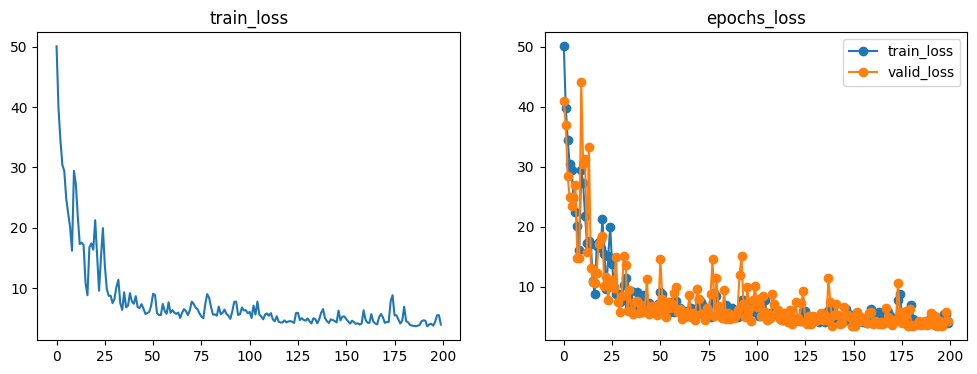

In [9]:
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.plot(train_epochs_loss[:])
plt.title("train_loss")
plt.subplot(122)
plt.plot(train_epochs_loss, '-o', label="train_loss")
plt.plot(valid_epochs_loss, '-o', label="valid_loss")
plt.title("epochs_loss")
plt.legend()
plt.show()

# Tester

In [10]:
def tester(final=True):
    print("***********- ***********- Init -*************")
    args = Args()

    print("***********- ***********- Read data and processing -*************")
    print("Loading data...")
    train_data = pd.read_csv(args.data_path+args.train_file).values
    test_data = pd.read_csv(args.data_path+args.test_file).values
    train_data, valid_data = train_valid_split(train_data, args.split_ratio, args.rand_seed)

    print("Selecting features...")
    x_train, _, x_test, _, _ = select_feat(train_data, valid_data, test_data, select_all=False)

    test_dataset = COVID19Dataset(x_test)
    test_dataloader = DataLoader(dataset=test_dataset, batch_size=args.batch_size, shuffle=False, pin_memory=True, num_workers=args.WORKERS)

    print("***********- ***********- Loading model -*************")
    if(len(args.gpus) == 0):
        model = My_Model(input_dim=x_train.shape[1])
        print("***********- ***********- Using CPU -*************")
    elif(len(args.gpus) == 1):
        model = My_Model(input_dim=x_train.shape[1]).cuda()
        print("***********- ***********- Using Single GPU -*************")
    else:
        gpus = ','.join(str(i) for i in args.gpus)
        os.environ["CUDA_VISIBLE_DEVICES"] = gpus
        model = My_Model(input_dim=x_train.shape[1]).cuda()
        gpus = [i for i in range(len(args.gpus))]
        model = torch.nn.DataParallel(model, device_ids=gpus)
        print("***********- ***********- Using Multi GPU -*************")
    
    model_best_path=args.MODEL_PATH+'/{}_best_params.pth'.format(args.model_name)
    model_final_path=args.MODEL_PATH+'/{}_final_params.pth'.format(args.model_name)
    
    if final:
        model.load_state_dict(torch.load(model_final_path))
        print("***********- ***********- Using Final Model -*************")
    else:
        model.load_state_dict(torch.load(model_best_path))
        print("***********- ***********- Using Best Model -*************")

    print("***********- ***********- Test begin -*************")
    preds = []
    model.eval()
    # =========================test=======================
    for idx, (X) in enumerate(tqdm(test_dataloader)):
        if (len(args.gpus) > 0):
            X = X.cuda()
        with torch.no_grad():
            outputs = model(X)
            preds.append(outputs.detach().cpu())
    preds = torch.cat(preds, dim=0).numpy()

    print("***********- ***********- Save predictions -*************")
    save_file = args.submit_file
    with open(save_file, 'w') as fp:
        writer = csv.writer(fp)
        writer.writerow(['id', 'tested_positive'])
        for i, p in enumerate(preds):
            writer.writerow([i, p])

    print("***********- ***********- Test finished -*************")

# Testing

In [11]:
tester(final=True)

***********- ***********- Init -*************
***********- ***********- Read data and processing -*************
Loading data...
Selecting features...
***********- ***********- Loading model -*************
***********- ***********- Using Single GPU -*************
***********- ***********- Using Final Model -*************
***********- ***********- Test begin -*************


100%|██████████| 5/5 [00:00<00:00,  5.83it/s]

***********- ***********- Save predictions -*************
***********- ***********- Test finished -*************
